## Модель Фицхью-Нагумо
![FNModel](modelFN.png)

![FTauShapes](f_tau_shapes.png)

In [1]:
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
import seaborn as sns
%matplotlib notebook
import numpy as np
from tqdm import tqdm

In [14]:
# константы кусочно-линейной функции f(E)
C1 = 4
C2 = 1
C3 = 15

# константы кусочно-константной функции tau(E)
tau1 = 0.5
tau2 = 16.66
tau3 = 0.5

# границы кусочности функции f(E)
E1 = 0.018
E2 = ((C1 + C2) * E1 + C3) / (C3 + C2)

a = E1 * (C1 / C2)

# границы кусочности функции tau(E)
B1 = 0.01
B2 = 0.95

In [3]:
# Функция f(E)
def f(E):
    return -C1 * E if E < E1 else C2 * (E - a) if E1 <= E <= E2 else -C3 * (E - 1)

In [4]:
# Функция tau(E)
def tau(E):
    #return np.piecewise(E, [E < B1, ((E >= B1) & (E <= B2)), E > B2], [tau1, tau2, tau3])
    return tau1 if E < B1 else tau2 if B1 <= E <= B2 else tau3

In [5]:
def f_vec(E):
    x = np.zeros(E.shape)
    x += (E < E1) * -C1 * E
    x += ((E >= E1) & (E <= E2)) * C2 * (E - a)
    x += (E > E2) * -C3 * (E - 1)
    return x

In [6]:
def tau_vec(E):
    x = np.zeros(E.shape)
    x += (E < B1) * tau1
    x += ((E >= B1) & (E <= B2)) * tau2
    x += (E > B2) * tau3
    return x

In [7]:
step = 1.2
x_max = 72*2
x = np.arange(0.0, x_max, step)
y_max = 72*2
y = np.arange(0.0, y_max, step)
step_t = 0.12
t_max = 300

### Original

In [ ]:
E = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))
g = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))

### Изменение первого слоя
E[:30,20,0] = 1
###

for i in tqdm(range(1, E.shape[2])):
    prev_E_layer = E[:,:,i-1]
    new_E_layer = E[:,:,i]
    prev_g_layer = g[:,:,i-1]
    new_g_layer = g[:,:,i]
    for m in range(0, E.shape[0]-1):
        for n in range(0, E.shape[1]-1):
            new_g_layer[m][n] = prev_g_layer[m][n] + step_t * (
                prev_E_layer[m][n] - prev_g_layer[m][n]
            ) / tau(prev_E_layer[m][n])
            new_E_layer[m][n] = prev_E_layer[m][n] + step_t * (
                (
                    prev_E_layer[m+1][n] + prev_E_layer[m-1][n] + prev_E_layer[m][n+1] + prev_E_layer[m][n-1] - 4*prev_E_layer[m][n]
                ) / step**2 + f(prev_E_layer[m][n]) - prev_g_layer[m][n]
            )

### Rolling

In [53]:
E = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))
g = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))

### Изменение первого слоя
E[:30,20,0] = 1
###

for i in tqdm(range(1, E.shape[2])):
    prev_E_layer = E[:,:,i-1]
    prev_g_layer = g[:,:,i-1]
    g[:,:,i] = prev_g_layer + step_t * (prev_E_layer - prev_g_layer) / tau_vec(prev_E_layer)
    E[:,:,i] = prev_E_layer + step_t * (
        (
            np.roll(prev_E_layer, 1, axis=0) + np.roll(prev_E_layer, -1, axis=0) + np.roll(prev_E_layer, 1, axis=1) + np.roll(prev_E_layer, -1, axis=1) - 4*prev_E_layer
        ) / step**2 + f_vec(prev_E_layer) - prev_g_layer
    )

100%|█████████████████| 2499/2499 [00:02<00:00, 891.79it/s]


### Padding

In [85]:
E = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))
g = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))

### Изменение первого слоя
E[1:30,20,0] = 1
###

for i in tqdm(range(1, E.shape[2])):
    prev_E_layer = E[:,:,i-1]
    prev_g_layer = g[:,:,i-1]
    g[:,:,i] = prev_g_layer + step_t * (prev_E_layer - prev_g_layer) / tau_vec(prev_E_layer)
    E[1:-1,1:-1,i] = prev_E_layer[1:-1,1:-1] + step_t * (
        (
            prev_E_layer[:-2,1:-1] + prev_E_layer[2:,1:-1] + prev_E_layer[1:-1,:-2] + prev_E_layer[1:-1,2:] - 4*prev_E_layer[1:-1,1:-1]
        ) / step**2 + f_vec(prev_E_layer[1:-1,1:-1]) - prev_g_layer[1:-1,1:-1]
    )

100%|████████████████| 2499/2499 [00:02<00:00, 1234.60it/s]


### Split

In [15]:
E = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))
g = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))

s0 = E.shape[0]
s1 = E.shape[1]

### Изменение первого слоя
E[:s0//2,s1//2,0] = 1
###
split_removed_at = 200

for i in tqdm(range(1, E.shape[2])):
    prev_E_layer = E[:,:,i-1]
    prev_g_layer = g[:,:,i-1]
    g[:,:,i] = prev_g_layer + step_t * (prev_E_layer - prev_g_layer) / tau_vec(prev_E_layer)
    E[1:-1,1:-1,i] = prev_E_layer[1:-1,1:-1] + step_t * (
        (
            prev_E_layer[:-2,1:-1] + prev_E_layer[2:,1:-1] + prev_E_layer[1:-1,:-2] + prev_E_layer[1:-1,2:] - 4*prev_E_layer[1:-1,1:-1]
        ) / step**2 + f_vec(prev_E_layer[1:-1,1:-1]) - prev_g_layer[1:-1,1:-1]
    )
    if i < split_removed_at:
        g[s0//2:s0//2+1,:,i] = np.zeros(g[s0//2:s0//2+1,:,i].shape)
        E[s0//2:s0//2+2,:,i] = np.zeros(E[s0//2:s0//2+1,:,i].shape)

100%|█████████████████| 2499/2499 [00:15<00:00, 158.97it/s]


In [139]:
animation_step = 10

def animate(t):
    sns.heatmap(E[:,:,t*animation_step], cbar=False, xticklabels=False, yticklabels=False)

<IPython.core.display.Javascript object>


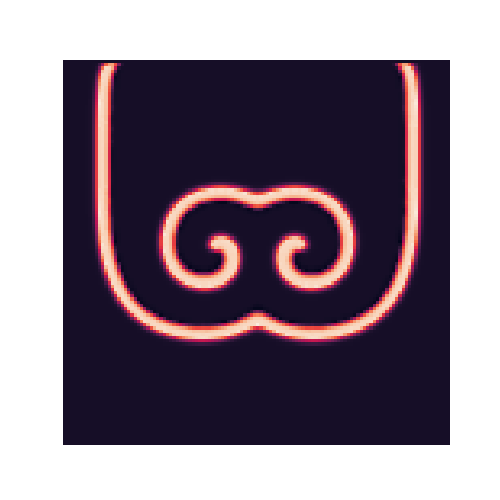

In [165]:
fig, ax = plt.subplots(figsize=(5,5))
ani = animation.FuncAnimation(fig, animate, frames=E.shape[2] // animation_step, repeat=False)

<IPython.core.display.Javascript object>


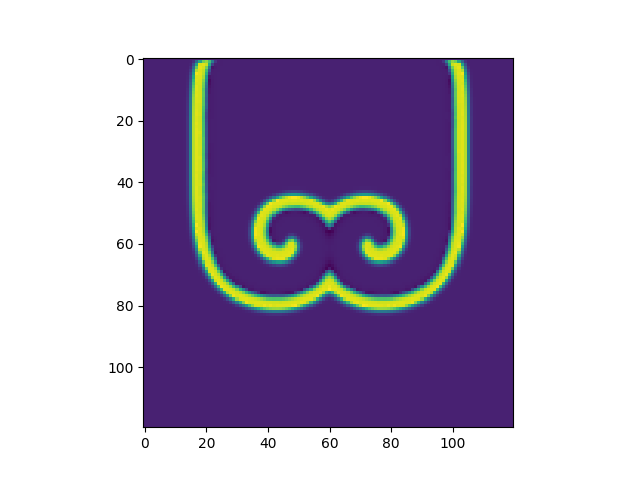

In [170]:
plt.imshow(E[:,:,420])

In [17]:
E = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))
g = np.zeros((int(x_max // step), int(y_max // step), int(t_max // step_t)))

s0 = E.shape[0]
s1 = E.shape[1]

### Изменение первого слоя
E[:s0//2,1,0] = 1
E[s0//2:,-2,0] = 1
###
split_removed_at = 400

for i in tqdm(range(1, E.shape[2])):
    prev_E_layer = E[:,:,i-1]
    prev_g_layer = g[:,:,i-1]
    g[:,:,i] = prev_g_layer + step_t * (prev_E_layer - prev_g_layer) / tau_vec(prev_E_layer)
    E[1:-1,1:-1,i] = prev_E_layer[1:-1,1:-1] + step_t * (
        (
            prev_E_layer[:-2,1:-1] + prev_E_layer[2:,1:-1] + prev_E_layer[1:-1,:-2] + prev_E_layer[1:-1,2:] - 4*prev_E_layer[1:-1,1:-1]
        ) / step**2 + f_vec(prev_E_layer[1:-1,1:-1]) - prev_g_layer[1:-1,1:-1]
    )
    if i < split_removed_at:
        g[s0//2:s0//2+1,:,i] = np.zeros(g[s0//2:s0//2+1,:,i].shape)
        E[s0//2:s0//2+2,:,i] = np.zeros(E[s0//2:s0//2+1,:,i].shape)

100%|█████████████████| 2499/2499 [00:12<00:00, 195.71it/s]


In [145]:
animation_step = 10

def animate(t):
    sns.heatmap(E[:,:,t*animation_step], cbar=False, xticklabels=False, yticklabels=False)

<IPython.core.display.Javascript object>


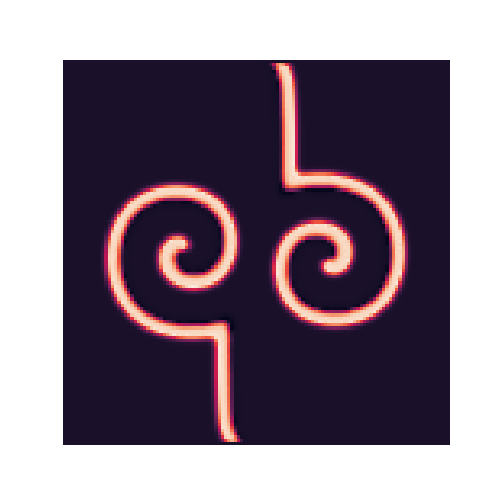

In [146]:
fig, ax = plt.subplots(figsize=(5,5))
ani = animation.FuncAnimation(fig, animate, frames=E.shape[2] // animation_step, repeat=False)

In [9]:
def grid_display(imgs, columns=None, convert_bgr=True):
    if columns is None:
        columns = len(imgs)
    rows = int(float(len(imgs)) / 2 + 1)
    fig = plt.figure(figsize=(10*columns, 10*rows))
    ax = []
    i = 0
    for img in tqdm(imgs):
        #img = cv2.resize(img, (int(img.shape[1] / img.shape[0] * 200), 200), interpolation = cv2.INTER_AREA)
        ax.append(fig.add_subplot(rows, columns, i+1))
        plt.imshow(img)
        i += 1
    plt.show()

In [16]:
E_ = E

<IPython.core.display.Javascript object>


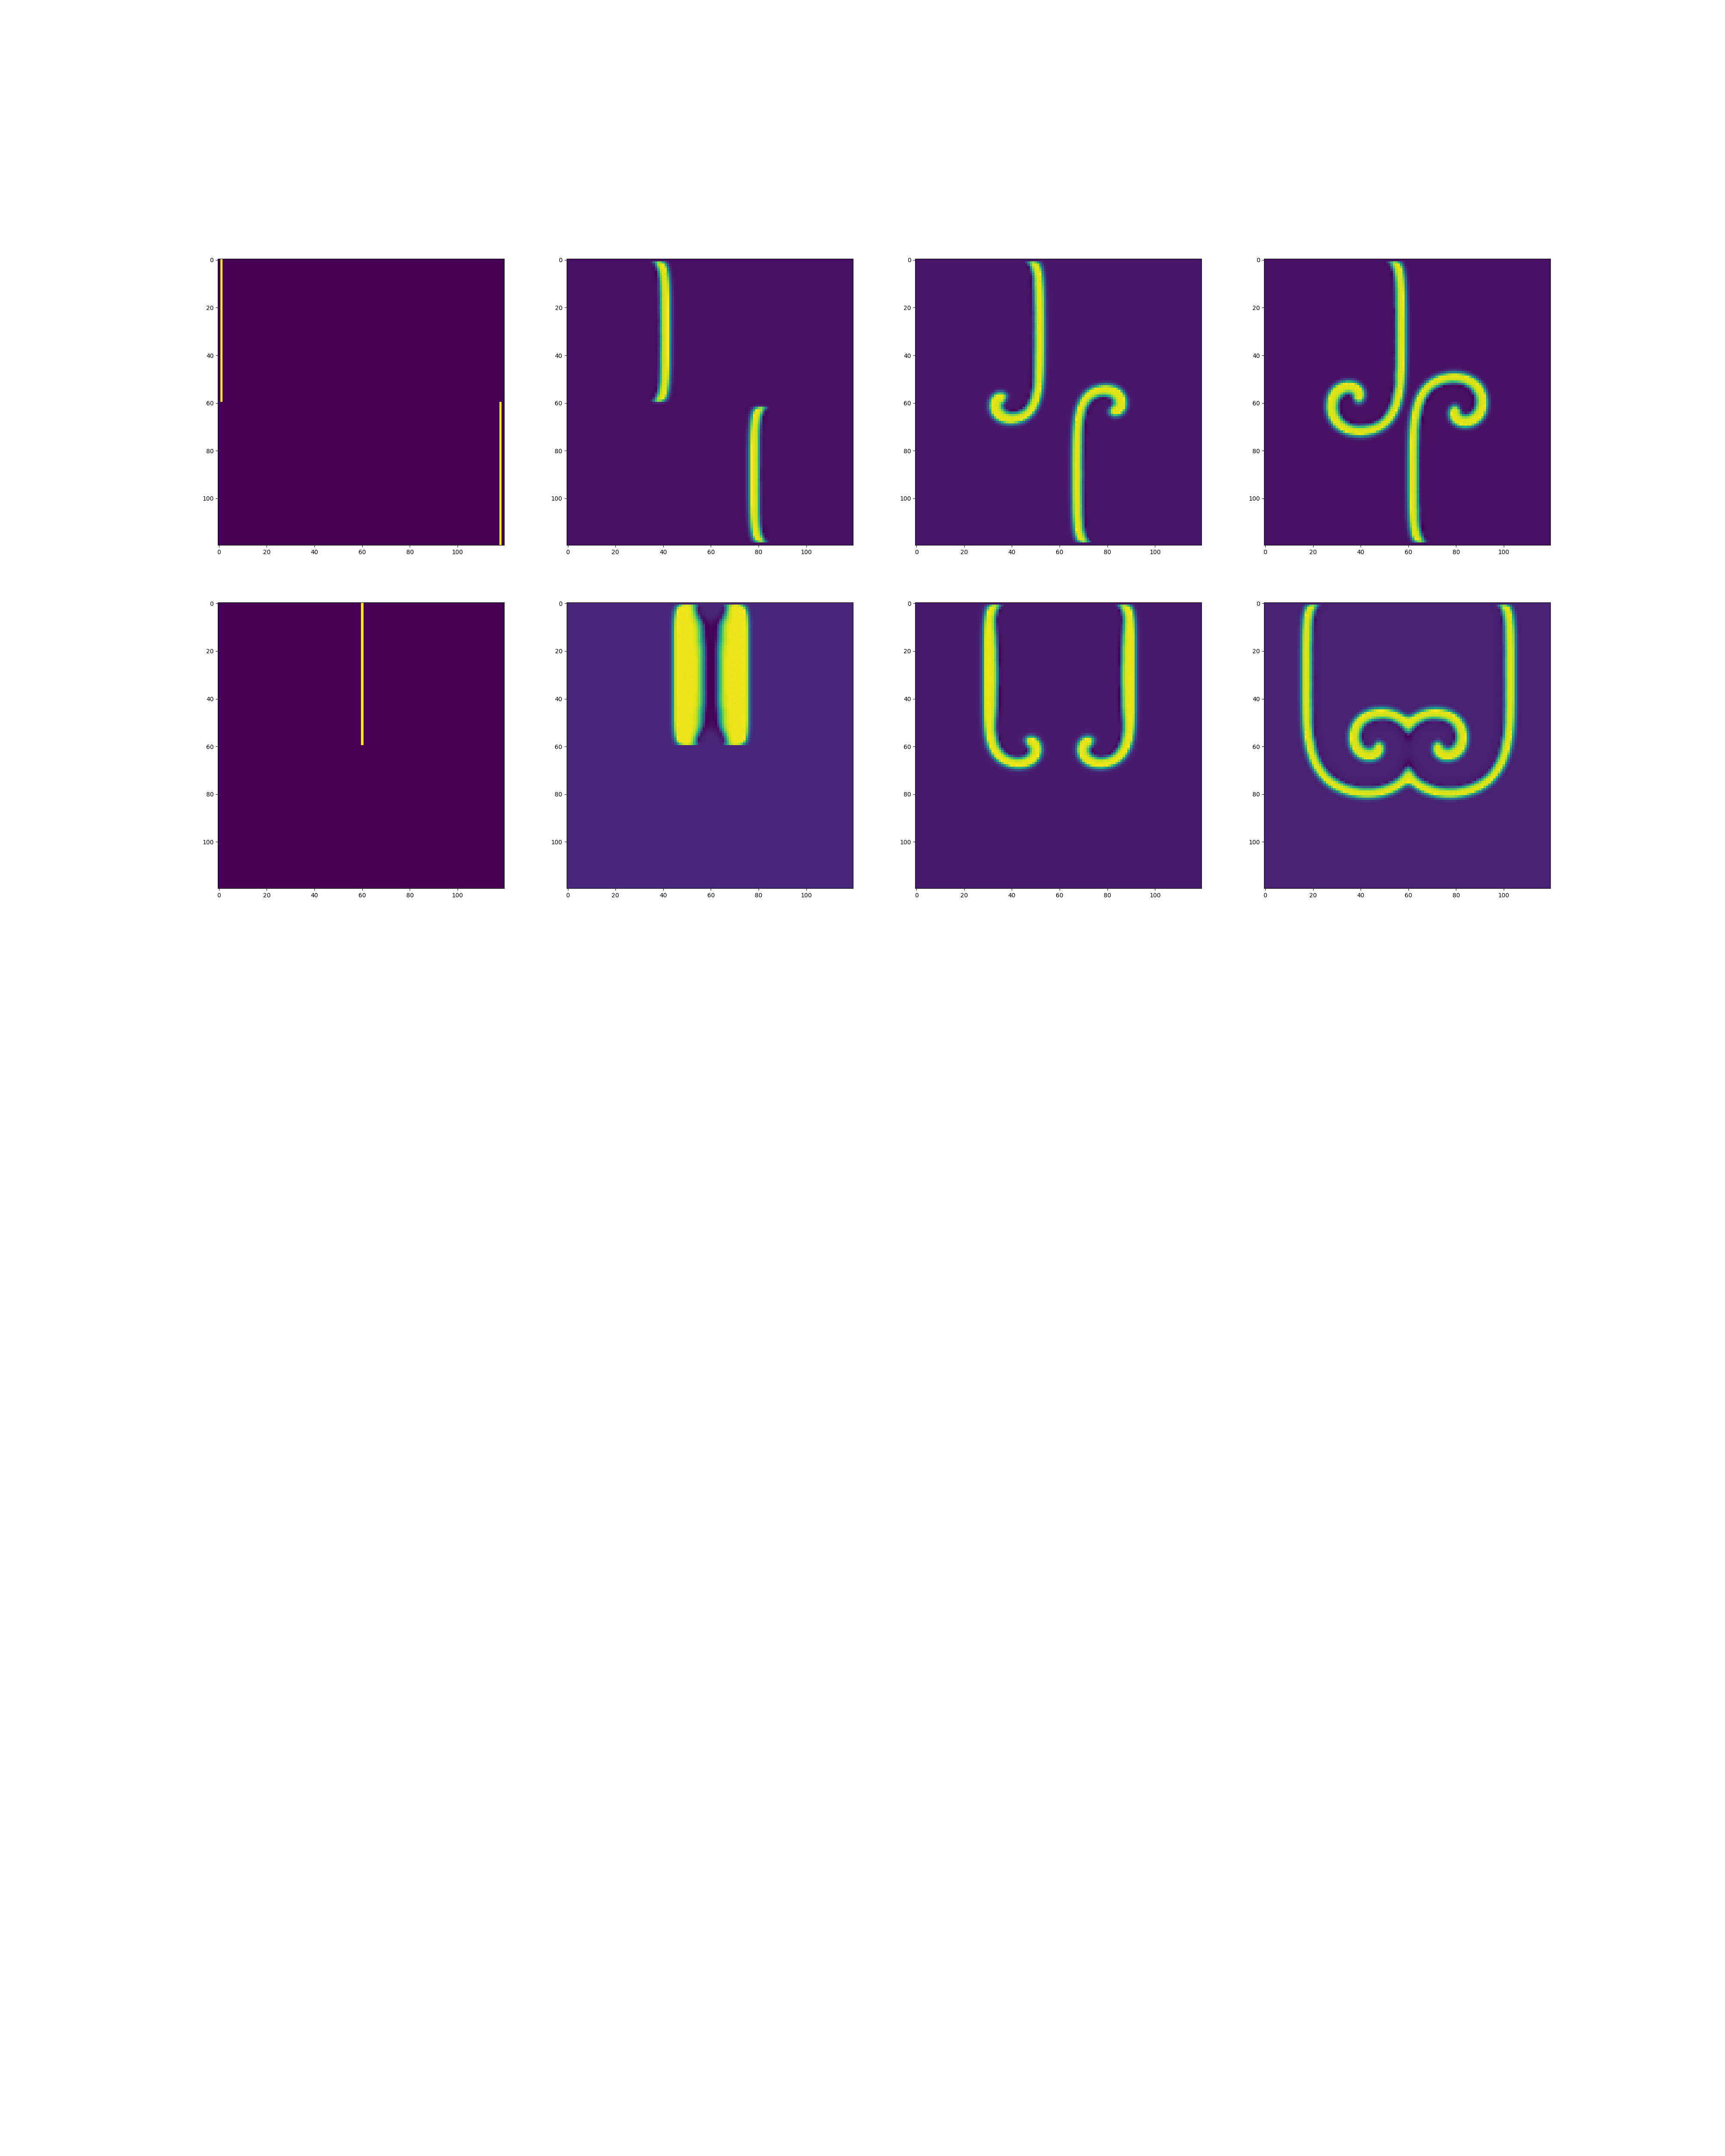

100%|████████████████████████| 8/8 [00:00<00:00, 26.92it/s]


In [19]:
grid_display([E[:,:,0], E[:,:,400], E[:,:,500], E[:,:,550], E_[:,:,0], E_[:,:,150], E_[:,:,300], E_[:,:,420]], 4)